# Ноутбук 03: Baseline Models

**Цель:**

- Обучить простые модели для сравнения с трансформером. Это baseline — точка отсчёта для оценки сложных моделей.

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

## Загрузка данных

In [32]:
X_train = np.load('../data/processed/X_train.npy')
y_train = np.load('../data/processed/y_train.npy')
X_val = np.load('../data/processed/X_val.npy')
y_val = np.load('../data/processed/y_val.npy')
mask_train = np.load('../data/processed/mask_train.npy')
mask_val = np.load('../data/processed/mask_val.npy')
class_weights = np.load('../data/processed/class_weights.npy')

## Метрики

In [33]:
def calculate_q3(y_true, y_pred, mask=None):
    """
    Q3 accuracy: процент правильно предсказанных остатков
    """
    if mask is not None:
        # Игнорируем padding
        y_true = y_true[mask == 1]
        y_pred = y_pred[mask == 1]
    
    return accuracy_score(y_true, y_pred)

def calculate_per_class_metrics(y_true, y_pred, mask=None):
    """
    Per-class precision, recall, F1
    """
    if mask is not None:
        y_true = y_true[mask == 1]
        y_pred = y_pred[mask == 1]
    
    return classification_report(y_true, y_pred, 
                                target_names=['H', 'E', 'C'],
                                labels=[1, 2, 3])


## Baseline 1 — SVC (Support Vector Classifier)

Самый простой подход: независимое предсказание для каждой позиции

In [34]:
# SVC не работает с последовательностями напрямую
# Нужно "развернуть" данные: каждая позиция = отдельный пример

def prepare_data_for_svc(X, y, mask, max_samples=50000):
    """
    Превращаем последовательности в отдельные примеры
    X: (N, seq_len) → X_flat: (N*seq_len, 1)
    """
    X_flat = []
    y_flat = []
    
    for i in range(len(X)):
        # Берём только валидные позиции (без padding)
        valid_positions = mask[i] == 1
        
        X_flat.extend(X[i][valid_positions])
        y_flat.extend(y[i][valid_positions])
        
        if len(X_flat) >= max_samples:
            break
    
    return np.array(X_flat[:max_samples]).reshape(-1, 1), np.array(y_flat[:max_samples])


X_train_svc, y_train_svc = prepare_data_for_svc(X_train, y_train, mask_train)
X_val_svc, y_val_svc = prepare_data_for_svc(X_val, y_val, mask_val)

## Обучение SVC

In [35]:
svc_model = LinearSVC(max_iter=1000, random_state=42, class_weight='balanced')
svc_model.fit(X_train_svc, y_train_svc)

,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,verbose,0
,random_state,42


## Оценка LinearSVC

In [36]:
# Предсказание LinearSVC
y_pred_svc = svc_model.predict(X_val_svc)

# Метрики
q3_svc = calculate_q3(y_val_svc, y_pred_svc)
print(f"\n📊 LinearSVC Results:")
print(f"Q3 Accuracy: {q3_svc:.4f} ({q3_svc*100:.2f}%)")
print("\nPer-class metrics:")
print(calculate_per_class_metrics(y_val_svc, y_pred_svc))


📊 LinearSVC Results:
Q3 Accuracy: 0.4500 (45.00%)

Per-class metrics:
              precision    recall  f1-score   support

           H       0.00      0.00      0.00     17264
           E       0.31      0.05      0.09     10178
           C       0.45      0.97      0.62     22558

    accuracy                           0.45     50000
   macro avg       0.26      0.34      0.24     50000
weighted avg       0.27      0.45      0.30     50000



c:\Users\Albert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Albert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Albert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(

## Baseline 2: Logistic Regression

Простая линейная модель — быстрая и часто сильная для разреженных данных.


In [37]:
lr_model = LogisticRegression(
    solver='saga',           # Хорошо для больших данных
    max_iter=200,
    class_weight='balanced', # Учёт дисбаланса классов
    random_state=42,
    n_jobs=-1,              # Параллельно на всех ядрах
    verbose=1
)

lr_model.fit(X_train_svc, y_train_svc)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


convergence after 26 epochs took 0 seconds


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'saga'
,max_iter,200
,multi_class,'deprecated'


### Оценка Logistic Regression


In [38]:
# Предсказание
y_pred_lr = lr_model.predict(X_val_svc)

# Метрики
q3_lr = calculate_q3(y_val_svc, y_pred_lr)
print(f"\n📊 Logistic Regression Results:")
print(f"Q3 Accuracy: {q3_lr:.4f} ({q3_lr*100:.2f}%)")
print("\nPer-class metrics:")
print(calculate_per_class_metrics(y_val_svc, y_pred_lr))


📊 Logistic Regression Results:
Q3 Accuracy: 0.2870 (28.70%)

Per-class metrics:
              precision    recall  f1-score   support

           H       0.35      0.48      0.40     17264
           E       0.21      0.47      0.29     10178
           C       0.31      0.06      0.10     22558

    accuracy                           0.29     50000
   macro avg       0.29      0.33      0.27     50000
weighted avg       0.30      0.29      0.25     50000



## Baseline 3: Random Forest

Ансамбль деревьев решений — устойчив к шуму и часто даёт сильный baseline.


In [39]:
rf_model = RandomForestClassifier(
    n_estimators=200,         # Количество деревьев
    max_depth=20,             # Ограничиваем глубину для скорости
    class_weight='balanced_subsample',  # Учёт дисбаланса
    n_jobs=-1,                # Параллельно на всех ядрах
    random_state=42,
    verbose=1
)

rf_model.fit(X_train_svc, y_train_svc)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.9s finished


,n_estimators,200
,criterion,'gini'
,max_depth,20
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### Оценка Random Forest


In [40]:
# Предсказание
y_pred_rf = rf_model.predict(X_val_svc)

# Метрики
q3_rf = calculate_q3(y_val_svc, y_pred_rf)
print(f"\n📊 Random Forest Results:")
print(f"Q3 Accuracy: {q3_rf:.4f} ({q3_rf*100:.2f}%)")
print("\nPer-class metrics:")
print(calculate_per_class_metrics(y_val_svc, y_pred_rf))

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.0s finished



📊 Random Forest Results:
Q3 Accuracy: 0.4635 (46.35%)

Per-class metrics:
              precision    recall  f1-score   support

           H       0.44      0.52      0.47     17264
           E       0.32      0.44      0.37     10178
           C       0.63      0.43      0.51     22558

    accuracy                           0.46     50000
   macro avg       0.46      0.46      0.45     50000
weighted avg       0.50      0.46      0.47     50000



## Сравнение всех baseline моделей




              Model  Q3 Score   Q3 %
          LinearSVC   0.45004 45.00%
Logistic Regression   0.28698 28.70%
      Random Forest   0.46348 46.35%


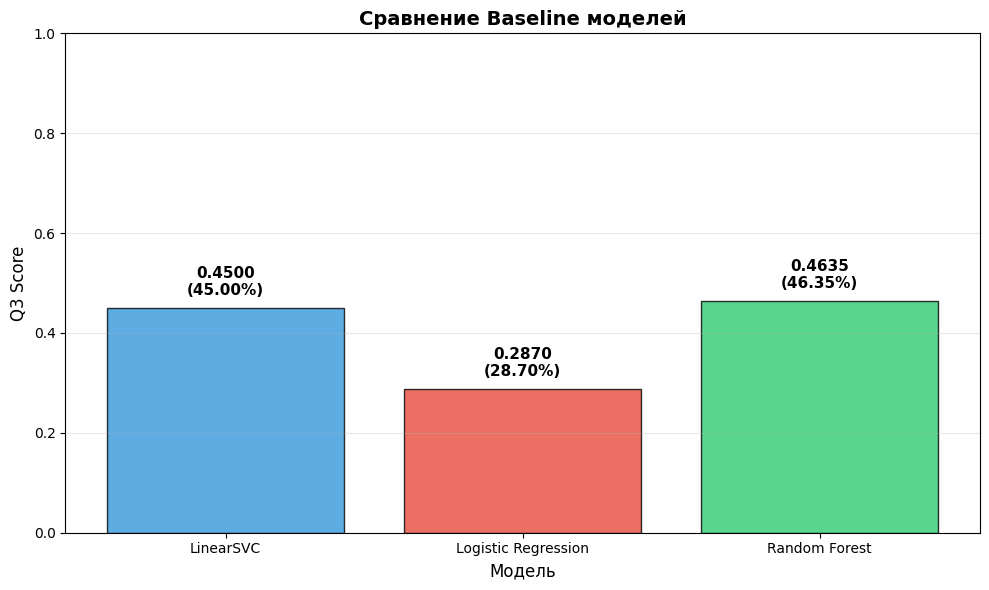


Лучшая модель: Random Forest с Q3 = 0.4635 (46.35%)


In [41]:
results = {
    'Model': ['LinearSVC', 'Logistic Regression', 'Random Forest'],
    'Q3 Score': [q3_svc, q3_lr, q3_rf],
    'Q3 %': [f'{q3_svc*100:.2f}%', f'{q3_lr*100:.2f}%', f'{q3_rf*100:.2f}%']
}

results_df = pd.DataFrame(results)
print("\n")
print(results_df.to_string(index=False))


plt.figure(figsize=(10, 6))
colors = ['#3498db', '#e74c3c', '#2ecc71']
bars = plt.bar(results_df['Model'], results_df['Q3 Score'], color=colors, alpha=0.8, edgecolor='black')

plt.xlabel('Модель', fontsize=12)
plt.ylabel('Q3 Score', fontsize=12)
plt.title('Сравнение Baseline моделей', fontsize=14, fontweight='bold')
plt.ylim(0, 1.0)
plt.grid(axis='y', alpha=0.3)


for i, (bar, score) in enumerate(zip(bars, results_df['Q3 Score'])):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{score:.4f}\n({score*100:.2f}%)',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

best_idx = results_df['Q3 Score'].idxmax()
best_model = results_df.loc[best_idx, 'Model']
best_score = results_df.loc[best_idx, 'Q3 Score']

print(f"\nЛучшая модель: {best_model} с Q3 = {best_score:.4f} ({best_score*100:.2f}%)")


## Выводы

Обучено 3 классических модели на 50,000 примерах:

| Модель | Q3 Score | 
|--------|----------|
| **LinearSVC** | 45.00% | 
| **Logistic Regression** | 28.70% | 
| **Random Forest** | 46.35% |

### Наблюдения

1. **Лучшая модель:** Random Forest
2. **Дисбаланс классов:** Все модели используют `class_weight='balanced'` для компенсации
3. **Ограничения:**
   - Модели видят только **одну аминокислоту** без контекста
   - Это объясняет низкую точность
   - Для улучшения нужен контекст (окно соседей или нейросети)